# Novel Recombinants Analysis

This notebook contains supplementary analyses of the 929 novel recombinants identified in the `sc2ts` paper.

## Dependencies

1. **Install python dependencies using `conda` (or a `conda` derivative):**

    ```bash
     micromamba env create -f notebooks/novel-recombinants-analysis.yml
    ```

2. **Install conda environment as a jupyter kernel.**

    ```bash
    python -m ipykernel install --user --name=novel-recombinants
    ```

3. **Select `ncov-recombinants` kernel for this notebook.**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import collections
import json
import os
import shutil

In [2]:
curr_dir = os.path.basename(os.getcwd())

# If we're still in the notebooks directory, move up to the project root.
if curr_dir != "sc2ts-paper":
  sc2ts_dir = os.path.join(os.getcwd(), "..")
  _ = os.chdir(sc2ts_dir)

## Data

- Viridan metadata: `data/run_metadata.v04.tsv.gz`
   - URL: https://figshare.com/articles/dataset/Supplementary_table_S1/25712982?file=45969195
- Viridian sequences: `data/Viridian_tree_cons_seqs/<#>.cons.fa.xz`
   - URL: https://doi.org/10.6084/m9.figshare.25713225
- Viridian index: `data/Viridian_tree_cons_seqs/index.tsv.xz`

> **Note**: Keep files in their compressed form (`gz`, `xz`), we will use tools that don't need decompression first.

Change the working directory to the root of the `sc2ts-paper` project.

Setup input/output files and directories.

In [3]:
metadata = os.path.join("data", "run_metadata.v04.tsv.gz")
sequences = os.path.join("data", "Viridian_tree_cons_seqs")
index = os.path.join("data", "Viridian_tree_cons_seqs", "index.tsv.xz")
recombinants = os.path.join("data", "recombinants.csv")
results = os.path.join("results", "novel_recombinants")
nextclade_dataset = os.path.join("dataset", "nextclade")
                                  
if not os.path.exists(results):
  os.makedirs(results)
if not os.path.exists(nextclade_dataset):
  os.makedirs(nextclade_dataset)

## Dependencies

### Install csvtk

`csvtk` is used as a unix-based dataframe engine.

In [ ]:
! wget -q -O csvtk.tar.gz https://github.com/shenwei356/csvtk/releases/download/v0.32.0/csvtk_linux_386.tar.gz
! tar -xf csvtk.tar.gz
! mv csvtk bin/
! rm -f csvtk.tar.gz
! bin/csvtk --help | head -n 5

### Install seqkit

`seqkit` is a unix-based tool for sequence queries and manipulation.

In [ ]:
! wget -q -O seqkit.tar.gz https://github.com/shenwei356/seqkit/releases/download/v2.9.0/seqkit_linux_amd64.tar.gz
! tar -xf seqkit.tar.gz
! mv seqkit bin/
! rm -f seqkit.tar.xz
! bin/seqkit --help | head -n 5

### Install nextclade

`nextclade` is a unix-based tool for sequence alignment and lineage assignment.

In [ ]:
! wget -q -O bin/nextclade https://github.com/nextstrain/nextclade/releases/download/3.10.2/nextclade-x86_64-unknown-linux-musl
! bin/nextclade --help | head -n 5

### Install rebar

`rebar` is a unix-based tool for recombinant sequence detection.

In [ ]:
! wget -q -O bin/rebar https://github.com/phac-nml/rebar/releases/download/v0.2.1/rebar-x86_64-unknown-linux-musl
! bin/rebar --help | head -n 5

### Install pangonet

`pangonet` is a python package and CLI tool for manipulating SARS-CoV-2 lineages in a recombination-aware, phylogenetic network.

Mainly, it's useful for getting ancestral/descendant relationships of lineages.

In [ ]:
! git clone https://github.com/phac-nml/pangonet.git
! cd pangonet && pip install . && cd -
! pangonet --help | head

In [22]:
from pangonet.pangonet import PangoNet

alias_key_path = os.path.join("dataset", "rebar", "alias_key.json")
lineage_notes_path = os.path.join("dataset", "rebar", "lineage_notes.txt")
pango = PangoNet().build(alias_key=alias_key_path, lineage_notes=lineage_notes_path)

2025-03-17 13:31:14,246 INFO:Creating aliases.
2025-03-17 13:31:14,263 INFO:Creating network.


## Metadata and Sequences

Extract Viridian metadata for the novel recombinants.

In [ ]:
! bin/csvtk cut -f sample_id {recombinants} \
  | tail -n+2 \
  | bin/csvtk grep -t -f Run -P - {metadata} \
  | bin/csvtk merge -t -f Run {index} - | \
  > {results}/metadata.tsv

pd.read_csv(f"{results}/metadata.tsv", sep="\t")

Extract Viridian batch numbers for the novel recombinants.

In [ ]:
! bin/csvtk cut -t -f Batch {results}/metadata.tsv | tail -n+2 | sort -g | uniq > {results}/batches.txt

Extract Viridian consensus sequences for the novel recombinants.

In [ ]:
! cat results/novel_recombinants/batches.txt | while read batch; do \
  echo Batch: ${batch} 1>&2; \
  bin/csvtk grep -t -f Batch -p ${batch} results/novel_recombinants/metadata.tsv \
    | bin/csvtk cut -t -f Run \
    | tail -n+2 \
    | bin/seqkit grep -w 0 -f - data/Viridian_tree_cons_seqs/${batch}.cons.fa.xz; \
done > results/novel_recombinants/sequences.fasta

## Align

Download the sars-cov-2 lineage model.

In [ ]:
! bin/nextclade dataset get \
  --name sars-cov-2 \
  --tag  2025-01-28--16-39-09Z \
  --output-dir dataset/nextclade

Align the sequences.

In [ ]:
! bin/nextclade run \
  --input-dataset dataset/nextclade \
  --jobs 2 \
  --output-tsv {results}/nextclade.tsv \
  --output-fasta {results}/nextclade.fasta \
  {results}/sequences.fasta

### Detect Recombination

Download the sars-cov-2 lineage model.

In [ ]:
! bin/rebar dataset download \
  --name sars-cov-2 \
  --tag 2025-01-28 \
  --verbosity error \
  --output-dir dataset/rebar

Detection recombination in the sequences.

In [ ]:
! bin/rebar run \
  --dataset-dir dataset/rebar \
  --threads 2 \
  --alignment {results}/nextclade.fasta \
  --output-dir {results}/rebar

! cp {results}/rebar/linelist.tsv data/rebar.tsv

Plot parents and breakpoints.

In [ ]:
! bin/rebar plot \
  --run-dir {results}/rebar \
  --annotations dataset/rebar/annotations.tsv \
  --verbosity error

## Compare

### Data

In [4]:
df_sc2ts = pd.read_csv("data/recombinants.csv", index_col=0).set_index("sample_id")
df_sc2ts

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,parent_left_pango,parent_right,parent_right_pango,mrca,t_mrca,diffs,max_run_length
sample_id,,,,,,,,,,,,,,,,,
ERR9939974,1280342,1,1280341,BA.4.1,695,958,1,2022-06-27,96ff31d5f4931e21077b36d955f3d19b,1253363,BA.5.2.1,1232376,BA.4.1,59,1114.000001,25,1
SRR20259474,663484,1,663483,AY.44,510,1222,1,2021-10-21,1476c0b3d53ecc0005cc7f9e58bd0112,484484,AY.43,588497,AY.44,220185,693.000015,20,2
ERR10219711,1356368,2,1356367,BA.4,695,1453,1,2022-08-30,a8925084fcc5a3a4b295a6749caf3a84,1253363,BA.5.2.1,1246039,BA.4,59,1114.000001,25,1
ERR9848224,1253364,855,1253363,BA.5.2.1,695,1627,1,2022-05-30,3db839925c532286df4889045c761caa,987426,BA.1,1236149,BA.5.2.1,59,1114.000001,85,8
ERR9940192,1279026,662,1279025,BA.5.1,695,1627,0,2022-06-26,12ba9c78bd850e33a1643682ab88327b,1253363,BA.5.2.1,1189178,BA.5.1,59,1114.000001,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR20772183,1226050,2,1226049,BA.2.12.1,23674,29729,0,2022-04-30,733362e3d149c31c2e5d401e3b17b245,1115252,BA.2.12.1,1054868,BA.2,843172,447.000000,12,2
SRR21671244,1362718,2,1362717,BA.5.1,29667,29729,3,2022-09-06,335aff0f853b55f8346ff9e4e35a2005,1292708,BA.5.1,1054868,BA.2,791357,464.750000,35,3
ERR10933490,1436032,2,1436031,XBB.1.5.4,27916,29729,3,2023-02-13,fc84b5db6f4d67e1ed8ffad030047211,1411836,XBB.1,1054868,BA.2,843172,447.000000,33,2


In [5]:
df_rebar = pd.read_csv("data/rebar.tsv", sep="\t").set_index("strain")
df_rebar

,validate,validate_details,population,recombinant,parents,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version
strain,,,,,,,,,,,,,,
ERR4615866,NaN,NaN,B.1.221,novel,"B.1.177,B.1.221",15325-20660,False,novel_B.1.177_B.1.221_15325-20660,"222-15324|B.1.177,20661-29645|B.1.221","C222T,T445C,C6286T|B.1.177;C21855T,A23403G,A25...",29903,sars-cov-2,2025-01-28,0.2.0
ERR4638271,NaN,NaN,XBA,XBA,"BA.2,AY.45","9054-9343,27385-28460",False,XBA_BA.2_AY.45_9054-9343_27385-28460,"6402-9053|BA.2,9344-27384|AY.45,28461-29402|BA.2","G28881A,G28882A,G28883C|BA.2;G13812T|AY.45;A86...",29903,sars-cov-2,2025-01-28,0.2.0
ERR4758732,NaN,NaN,B.1.1.307,NaN,NaN,NaN,False,NaN,NaN,"C241T,C3037T,G9802T,G12067T,C14408T,A23403G,G2...",29903,sars-cov-2,2025-01-28,0.2.0
ERR5403161,NaN,NaN,B.1.177,novel,"B.1.1.1,B.1.177",4003-6285,False,novel_B.1.1.1_B.1.177_4003-6285,"204-4002|B.1.1.1,6286-29645|B.1.177","C241T,C3037T,C4002T|B.1.1.1;C6286T,C14408T,G21...",29903,sars-cov-2,2025-01-28,0.2.0
SRR14404787,NaN,NaN,B.1.2,NaN,NaN,NaN,False,NaN,NaN,"C241T,C1059T,C3037T,C10319T,C14408T,A18424G,C2...",29903,sars-cov-2,2025-01-28,0.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR10839848,NaN,NaN,XCT.1,XCT,"BJ.1,CH.1.1.2",18584-20740,False,XCT_BJ.1_CH.1.1.2_18584-20740,"405-18583|BJ.1,20741-29118|CH.1.1.2","A405G,C15738T,T15939C,T16342C,T17859C|BJ.1;A20...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10931828,NaN,NaN,CH.1.1.1,novel,"CH.1.1.1,CH.1.1.17",19887-21810,False,novel_CH.1.1.1_CH.1.1.17_19887-21810,"1545-19886|CH.1.1.1,21811-25721|CH.1.1.17","C1545T,C2790T,C3037T,C3796T,C3857A,C3927T,G418...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10921923,NaN,NaN,CH.1.1.1,novel,"BQ.1.1.29,CH.1.1.1",20742-22000,False,novel_BQ.1.1.29_CH.1.1.1_20742-22000,"1545-20741|BQ.1.1.29,22001-28681|CH.1.1.1","C1931A,T2954C,G7850A,T11374C,C11750T,G12160A,T...",29903,sars-cov-2,2025-01-28,0.2.0


In [7]:
dfj = df_sc2ts.join(df_rebar, rsuffix="_rebar")
dfj

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,...,parents,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR9939974,1280342,1,1280341,BA.4.1,695,958,1,2022-06-27,96ff31d5f4931e21077b36d955f3d19b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR20259474,663484,1,663483,AY.44,510,1222,1,2021-10-21,1476c0b3d53ecc0005cc7f9e58bd0112,484484,...,NaN,NaN,False,NaN,NaN,"G210T,C241T,C3037T,G4181T,C6040T,C6402T,C7124T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10219711,1356368,2,1356367,BA.4,695,1453,1,2022-08-30,a8925084fcc5a3a4b295a6749caf3a84,1253363,...,NaN,NaN,False,NaN,NaN,"C203T,C241T,T670G,T1453C,C2790T,C3037T,G4184A,...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9848224,1253364,855,1253363,BA.5.2.1,695,1627,1,2022-05-30,3db839925c532286df4889045c761caa,987426,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C1627T,C2790T,C3037T,G4184A,C4321T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9940192,1279026,662,1279025,BA.5.1,695,1627,0,2022-06-26,12ba9c78bd850e33a1643682ab88327b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR20772183,1226050,2,1226049,BA.2.12.1,23674,29729,0,2022-04-30,733362e3d149c31c2e5d401e3b17b245,1115252,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR21671244,1362718,2,1362717,BA.5.1,29667,29729,3,2022-09-06,335aff0f853b55f8346ff9e4e35a2005,1292708,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10933490,1436032,2,1436031,XBB.1.5.4,27916,29729,3,2023-02-13,fc84b5db6f4d67e1ed8ffad030047211,1411836,...,"BJ.1,BA.2.75",22897-22941,False,XBB_BJ.1_BA.2.75_22897-22941,"405-22896|BJ.1,22942-29118|BA.2.75","A405G,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0


### Filter

In [8]:
int(np.sum(dfj["recombinant_rebar"] == "novel"))

161

Overall, we have 161 recombinants marked as novel by rebar. Is the run_length diagnostic here in terms of picking these out?

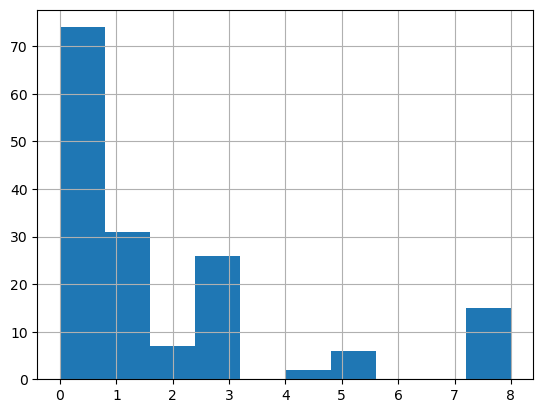

In [9]:
dfj[dfj["recombinant_rebar"] == "novel"].max_run_length.hist();

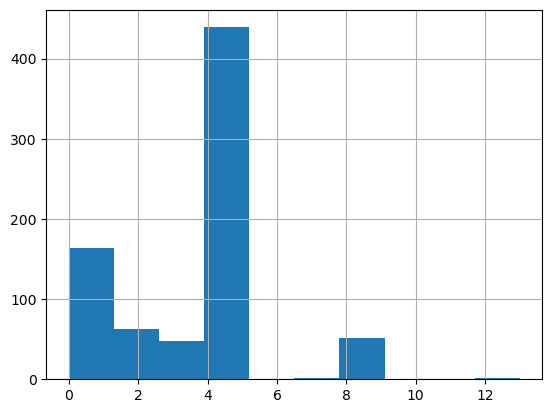

In [10]:
dfj[dfj["recombinant_rebar"] != "novel"].max_run_length.hist();

No, as it happens the vast majority of the errors have a run length of 5. So let's exclude these.

In [11]:
df_hq = dfj[dfj.max_run_length != 5]
df_hq

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,...,parents,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR9939974,1280342,1,1280341,BA.4.1,695,958,1,2022-06-27,96ff31d5f4931e21077b36d955f3d19b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR20259474,663484,1,663483,AY.44,510,1222,1,2021-10-21,1476c0b3d53ecc0005cc7f9e58bd0112,484484,...,NaN,NaN,False,NaN,NaN,"G210T,C241T,C3037T,G4181T,C6040T,C6402T,C7124T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10219711,1356368,2,1356367,BA.4,695,1453,1,2022-08-30,a8925084fcc5a3a4b295a6749caf3a84,1253363,...,NaN,NaN,False,NaN,NaN,"C203T,C241T,T670G,T1453C,C2790T,C3037T,G4184A,...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9848224,1253364,855,1253363,BA.5.2.1,695,1627,1,2022-05-30,3db839925c532286df4889045c761caa,987426,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C1627T,C2790T,C3037T,G4184A,C4321T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9940192,1279026,662,1279025,BA.5.1,695,1627,0,2022-06-26,12ba9c78bd850e33a1643682ab88327b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR20772183,1226050,2,1226049,BA.2.12.1,23674,29729,0,2022-04-30,733362e3d149c31c2e5d401e3b17b245,1115252,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR21671244,1362718,2,1362717,BA.5.1,29667,29729,3,2022-09-06,335aff0f853b55f8346ff9e4e35a2005,1292708,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10933490,1436032,2,1436031,XBB.1.5.4,27916,29729,3,2023-02-13,fc84b5db6f4d67e1ed8ffad030047211,1411836,...,"BJ.1,BA.2.75",22897-22941,False,XBB_BJ.1_BA.2.75_22897-22941,"405-22896|BJ.1,22942-29118|BA.2.75","A405G,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0


In [12]:
# Of the filtered sc2ts recombinants, rebar classifies
# 355 as non-recombinants,
# 155 as novel recombinants, and
# 68 as known recombinants.
counts = collections.Counter(df_hq["recombinant_rebar"])
df_counts = pd.DataFrame({"lineage": counts.keys(), "count": counts.values()}).sort_values("count", ascending=False).set_index("lineage")
df_counts

,count
lineage,
NaN,355
novel,155
XS,7
XM,7
XAS,6
XAN,5
XAB,4
XAP,4
XY,3


In [13]:
# TODO: Analyse these later.
df_nonrecomb = df_hq[df_hq["recombinant_rebar"].isna()]
df_nonrecomb

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,...,parents,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR9939974,1280342,1,1280341,BA.4.1,695,958,1,2022-06-27,96ff31d5f4931e21077b36d955f3d19b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR20259474,663484,1,663483,AY.44,510,1222,1,2021-10-21,1476c0b3d53ecc0005cc7f9e58bd0112,484484,...,NaN,NaN,False,NaN,NaN,"G210T,C241T,C3037T,G4181T,C6040T,C6402T,C7124T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR10219711,1356368,2,1356367,BA.4,695,1453,1,2022-08-30,a8925084fcc5a3a4b295a6749caf3a84,1253363,...,NaN,NaN,False,NaN,NaN,"C203T,C241T,T670G,T1453C,C2790T,C3037T,G4184A,...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9848224,1253364,855,1253363,BA.5.2.1,695,1627,1,2022-05-30,3db839925c532286df4889045c761caa,987426,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C1627T,C2790T,C3037T,G4184A,C4321T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9940192,1279026,662,1279025,BA.5.1,695,1627,0,2022-06-26,12ba9c78bd850e33a1643682ab88327b,1253363,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR10706966,1418709,37,1418697,BQ.1.21,28682,29729,8,2022-12-17,5872e2e5c8c65379cd79e24a8e4289a2,1335901,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C1931A,C2790T,T2954C,C3037T,G4184A...",29903,sars-cov-2,2025-01-28,0.2.0
SRR20772183,1226050,2,1226049,BA.2.12.1,23674,29729,0,2022-04-30,733362e3d149c31c2e5d401e3b17b245,1115252,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0
SRR21671244,1362718,2,1362717,BA.5.1,29667,29729,3,2022-09-06,335aff0f853b55f8346ff9e4e35a2005,1292708,...,NaN,NaN,False,NaN,NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...",29903,sars-cov-2,2025-01-28,0.2.0


In [14]:
df_recomb = df_hq[~df_hq["recombinant_rebar"].isna()]
df_recomb

,recombinant,descendants,sample,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,parent_left,...,parents,breakpoints,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR9380041,1145912,1,1145911,BA.1,2833,3542,0,2022-03-15,09d1037b37598cd55a55199a87fe9226,1001079,...,"BA.2,BA.1.1",2833-4183,False,novel_BA.2_BA.1.1_2833-4183,"670-2832|BA.2,4184-29510|BA.1.1","T670G,C2790T|BA.2;T5386G,G8393A,C10029T,C10449...",29903,sars-cov-2,2025-01-28,0.2.0
SRR15776056,417645,1,417644,AY.100,1878,4181,1,2021-08-14,f87b49c321f6f3af8e99fefebbe42bc7,388309,...,"AY.14,AY.100",1878-4180,False,novel_AY.14_AY.100_1878-4180,"1191-1877|AY.14,4181-28916|AY.100","C1191T,C1267T,T1877G|AY.14;G4181T,C6402T,C7124...",29903,sars-cov-2,2025-01-28,0.2.0
ERR9444530,1159411,32,1159410,XW,2833,4321,1,2022-03-20,2eb4972c99c3c77fc654e7ab58ec57e2,946560,...,"BA.1.1,BA.2",2833-4183,False,XW_BA.1.1_BA.2_2833-4183,"670-2832|BA.1.1,4184-29510|BA.2","C2470T,A2832G|BA.1.1;G4184A,C4321T,C9344T,A942...",29903,sars-cov-2,2025-01-28,0.2.0
ERR8495032,995727,5,995726,BA.2,4185,4321,0,2022-01-27,9692f8f5882b9b12e0350ff32098c646,956483,...,"BA.1,BA.2.10",4185-4320,False,XAR_BA.1_BA.2.10_4185-4320,"670-4184|BA.1,4321-29510|BA.2.10","A2832G,C3037T|BA.1;C4321T,C9344T,A9424G,C9534T...",29903,sars-cov-2,2025-01-28,0.2.0
ERR8691075,1058654,152,1058653,XQ,4322,5386,0,2022-02-12,f17cc10ee93e03ba45fc6bd20c517656,908002,...,"BA.1.1,BA.2.23",4322-5385,False,XQ_BA.1.1_BA.2.23_4322-5385,"2470-4321|BA.1.1,5386-29510|BA.2.23","C2470T,A2832G|BA.1.1;C9344T,A9424G,C9534T,C986...",29903,sars-cov-2,2025-01-28,0.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR5232711,105931,3,105930,B.1.1.7,25997,27972,2,2021-01-18,8ed8fa69ba674c6d6d85c7e2d22e1986,70379,...,"B.1.1.7,B.1.221",25997-27971,False,novel_B.1.1.7_B.1.221_25997-27971,"913-25996|B.1.1.7,27972-28977|B.1.221","C913T,C3037T,C3267T,C5388A,C5986T,T6954C,C1440...",29903,sars-cov-2,2025-01-28,0.2.0
ERR5304348,99000,1,98999,B.1.1,24915,27972,2,2021-01-12,04de7d375da9876402df184e81e82d1f,64598,...,"B.1.177,B.1.1.7",26802-27971,False,XA_B.1.177_B.1.1.7_26802-27971,"445-26801|B.1.177,27972-29645|B.1.1.7","T445C,C6286T,G21255C,C22227T,C26801G|B.1.177;C...",29903,sars-cov-2,2025-01-28,0.2.0
SRR21139593,1274474,21,1274473,BA.5.1,27439,28330,0,2022-06-20,4b4fd0a10ab1d5469052d865da659321,1263045,...,"BA.5.1,BF.38",27439-28329,False,novel_BA.5.1_BF.38_27439-28329,"1627-27438|BA.5.1,28330-29666|BF.38","C2790T,C3037T,G4184A,C4321T,C9344T,A9424G,C953...",29903,sars-cov-2,2025-01-28,0.2.0


Do any of these recombinants have more than one breakpoint?

In [15]:
df_recomb = df_recomb\
    .assign(num_parents_rebar = [len(x.split(",")) for x in df_recomb["parents"].to_list()])\
    .assign(num_breakpoints_rebar = [len(x.split(",")) for x in df_recomb["breakpoints"].to_list()])

In [16]:
# How many recombinants have more than 2 parents as per rebar?
sum(df_recomb["num_parents_rebar"] > 2)

0

In [17]:
# How many recombinants have more than 1 breakpoint as per rebar?
sum(df_recomb["num_breakpoints_rebar"] > 1)

7

In [18]:
# 7 recombinants (only 1 novel) have more than one breakpoint. Exclude them.
df_recomb = df_recomb[
    (df_recomb["num_parents_rebar"] == 2) & \
    (df_recomb["num_breakpoints_rebar"] == 1)
]
len(df_recomb)

216

In [19]:
# 3 recombinants have "Unknown (R)" as per sc2ts. Exclude them.
# TODO: Investigate them.
df_recomb = df_recomb[
    (df_recomb["parent_left_pango"] != "Unknown (R)") & \
    (df_recomb["parent_right_pango"] != "Unknown (R)")
]
len(df_recomb)

213

### Disagreement

In [104]:
import copy

df_nonrecomb[
  (df_nonrecomb["num_mutations"] >= 3) & (df_nonrecomb["parent_left_pango"] != df_nonrecomb["parent_right_pango"])
][["parent_left_pango", "parent_right_pango"]]

is_rebar_candidate = [False for _ in range(0, len(df_nonrecomb))]
for i,data in enumerate(df_nonrecomb.iterrows()):
    index, row = data
    if row["num_mutations"] < 3: continue
    # Check for equivalent or sister taxa
    p1, p2 = row["parent_left_pango"], row["parent_right_pango"]
    if p1 == p2: continue
    anc, desc = pango.get_ancestors(p1), pango.get_descendants(p1)
    if p2 in anc or p2 in desc: continue         
    is_rebar_candidate[i] = True

df_nonrecomb["is_rebar_candidate"] = is_rebar_candidate
df_nonrecomb[df_nonrecomb["is_rebar_candidate"]][["parent_left_pango", "parent_right_pango", "num_mutations"]]

/tmp/ipykernel_1950/3416799169.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonrecomb["is_rebar_candidate"] = is_rebar_candidate


,parent_left_pango,parent_right_pango,num_mutations
sample_id,,,
SRR20186337,AY.54,AY.44,3
ERR10627135,BA.5.2.20,BN.1.3,3
SRR21440711,BA.2,BA.5.2,3
SRR16566613,AY.119,AY.3,3
ERR8203799,AY.4,AY.43,3
SRR18098223,AY.44,AY.120.1,3
ERR6574263,AY.42,AY.125,3
ERR6758858,AY.4,Unknown (R),3
ERR6769488,AY.80,AY.4,3


### Parents

Compare the Pango identities of the parents and the breakpoint intervals

In [20]:
df_recomb = df_recomb\
    .assign(left_parent_rebar = [x.split(",")[0] for x in df_recomb["parents"].to_list()])\
    .assign(right_parent_rebar = [x.split(",")[1] for x in df_recomb["parents"].to_list()])\
    .assign(left_breakpoint_rebar = [int(x.split("-")[0]) for x in df_recomb["breakpoints"].to_list()])\
    .assign(right_breakpoint_rebar = [int(x.split("-")[1]) for x in df_recomb["breakpoints"].to_list()])

In [23]:
is_parents_concordant = np.zeros(len(df_recomb), dtype=bool)
i = 0
for index, row in df_recomb.iterrows():
    concordant_count = 0
    for p in ["left", "right"]:
        p_rebar = row[f"{p}_parent_rebar"]
        anc_rebar = pango.get_ancestors(p_rebar)
        desc_rebar = pango.get_descendants(p_rebar)
        p_sc2ts = row[f"parent_{p}_pango"]

        concordant = (p_rebar == p_sc2ts) or (p_sc2ts in anc_rebar) or (p_sc2ts in desc_rebar)
        # TBD: We could put a distance check here to make sure they're not
        # extremely distant related.
        concordant_count += 1 if concordant else 0

    # If both parents are concordant
    if concordant_count == 2:
        is_parents_concordant[i] = 1
    i +=1

df_tmp = df_recomb.assign(is_parents_concordant = is_parents_concordant)

df_recomb = df_recomb.assign(is_parents_concordant = is_parents_concordant)
df_recomb[["parent_left_pango", "parent_right_pango", "left_parent_rebar", "right_parent_rebar", "is_parents_concordant"]]

,parent_left_pango,parent_right_pango,left_parent_rebar,right_parent_rebar,is_parents_concordant
sample_id,,,,,
ERR9380041,BA.2.10,BA.1.1,BA.2,BA.1.1,True
SRR15776056,AY.14,AY.100,AY.14,AY.100,True
ERR9444530,BA.1.1.15,BA.2,BA.1.1,BA.2,True
ERR8495032,BA.1,BA.2.10,BA.1,BA.2.10,True
ERR8691075,BA.1.1.15,BA.2.9,BA.1.1,BA.2.23,False
...,...,...,...,...,...
ERR5232711,B.1.1.7,B.1.221.1,B.1.1.7,B.1.221,True
ERR5304348,B.1.177.16,B.1.1.7,B.1.177,B.1.1.7,True
SRR21139593,BA.5.1,BA.5.2.1,BA.5.1,BF.38,True


In [44]:
num_concordant = len(df_recomb[df_recomb['is_parents_concordant']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Parents: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

Concordant Parents: 182/213 (85.4%)


### Breakpoints

In [45]:
# TODO: Modify after figuring out what the rebar coordinates really mean.
# TODO: Refactor and move to utils.
def overlap_breakpoint_intervals(*, rebar_interval, sc2ts_interval):
    assert rebar_interval[0] < rebar_interval[1]
    assert sc2ts_interval[0] < sc2ts_interval[1]
    rebar_size = rebar_interval[1] - rebar_interval[0]
    sc2ts_size = sc2ts_interval[1] - sc2ts_interval[0]
    def _get_overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    overlap_size = _get_overlap(a=rebar_interval, b=sc2ts_interval)
    is_overlap_with_rebar = overlap_size > 0
    overlap_rebar_size_ratio = overlap_size / rebar_size
    sc2ts_rebar_size_ratio = sc2ts_size / rebar_size
    interval_distance = max(
        0,
        max(
            rebar_interval[0] - sc2ts_interval[1],
            sc2ts_interval[0] - rebar_interval[1],
        )
    )
    return (
        is_overlap_with_rebar,
        overlap_rebar_size_ratio,
        sc2ts_rebar_size_ratio,
        interval_distance,
    )


is_overlap_with_rebar = np.zeros(len(df_recomb), dtype=bool)
overlap_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
sc2ts_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
interval_distance = np.zeros(len(df_recomb), dtype=np.float32)

i = 0
for index, row in df_recomb.iterrows():
    (
        is_overlap_with_rebar[i], 
        overlap_rebar_size_ratio[i], 
        sc2ts_rebar_size_ratio[i],
        interval_distance[i],
    ) = overlap_breakpoint_intervals(
        rebar_interval=(row["left_breakpoint_rebar"], row["right_breakpoint_rebar"]),
        sc2ts_interval=(row["interval_left"], row["interval_right"]),
    )
    i += 1

df_recomb = df_recomb\
    .assign(is_overlap_with_rebar = is_overlap_with_rebar)\
    .assign(overlap_rebar_size_ratio = overlap_rebar_size_ratio)\
    .assign(sc2ts_rebar_size_ratio = sc2ts_rebar_size_ratio)\
    .assign(interval_distance = interval_distance)

df_recomb[["interval_left", "interval_right", "left_breakpoint_rebar", "right_breakpoint_rebar", "is_overlap_with_rebar"]]

,interval_left,interval_right,left_breakpoint_rebar,right_breakpoint_rebar,is_overlap_with_rebar
sample_id,,,,,
ERR9380041,2833,3542,2833,4183,True
SRR15776056,1878,4181,1878,4180,True
ERR9444530,2833,4321,2833,4183,True
ERR8495032,4185,4321,4185,4320,True
ERR8691075,4322,5386,4322,5385,True
...,...,...,...,...,...
ERR5232711,25997,27972,25997,27971,True
ERR5304348,24915,27972,26802,27971,True
SRR21139593,27439,28330,27439,28329,True


In [46]:
num_concordant = len(df_recomb[df_recomb['is_overlap_with_rebar']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Breakpoints: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

Concordant Breakpoints: 201/213 (94.4%)


### Plot

In [47]:
import matplotlib.pyplot as plt

# TODO: Refactor and move to utils.
def plot_breakpoint_interval_properties(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.suptitle(title)
    ax[0].set_ylabel("Number of recombinants")
    ax[0].set_xlabel("Interval overlap size / rebar interval size")
    ax[0].hist(df["overlap_rebar_size_ratio"], bins=30)
    ax[1].set_xlabel("sc2ts interval size / rebar interval size")
    ax[1].hist(df["sc2ts_rebar_size_ratio"], bins=30)
    ax[2].set_xlabel("Distance between intervals")
    ax[2].hist(df["interval_distance"], bins=30);

Novel recombinants as per rebar

In [48]:
df_novel = df_recomb[df_recomb["recombinant_rebar"] == "novel"]
len(df_novel)

152

In [49]:
# Cases where Pango parents are not concordant.
pd.set_option('display.max_rows', 100)
df_novel.loc[
    ~df_novel["is_parents_concordant"],
    [
        "descendants",
        "sample_pango",
        "parent_left_pango",
        "parent_right_pango",
        "left_parent_rebar",
        "right_parent_rebar",
    ]
]

,descendants,sample_pango,parent_left_pango,parent_right_pango,left_parent_rebar,right_parent_rebar
sample_id,,,,,,
ERR6457057,1,AY.9,AY.4.7,AY.9.2,AY.4.2,AY.9.2
SRR22973069,2,BQ.1.1,BA.5.6,BQ.1.22,BA.5.6.2,BQ.1.1
ERR5238288,1,B.1.177.9,B.1.1.7,B.1.177.9,B.1.1.7,B.1.177.10
SRR21737519,4,BA.5.2.1,BA.2.18,BF.26,BA.2.75,BF.26
SRR20940538,2,B.1.617.2,AY.25,AY.44,AY.121.1,AY.87
SRR15982371,1,B.1.617.2,AY.25,AY.26,AY.23,AY.26
ERR10427736,1,BE.1,BF.7.13.1,BE.1,BF.7.13.2,BE.1.1
SRR21042659,2,BA.2.12.1,BA.5.5,BA.2.12.1,BA.2.21,BG.5
SRR21948388,1,BA.5.2,BA.5.2.19,BF.10,BA.5.2.26,BF.10


In [50]:
# Cases where the breakpoint intervals do not overlap.
df_novel.loc[
    ~df_novel["is_overlap_with_rebar"],
    [
        "descendants",
        "interval_left",
        "interval_right",
        "left_breakpoint_rebar",
        "right_breakpoint_rebar",
        "overlap_rebar_size_ratio",
        "sc2ts_rebar_size_ratio",
        "interval_distance",
    ]
]

,descendants,interval_left,interval_right,left_breakpoint_rebar,right_breakpoint_rebar,overlap_rebar_size_ratio,sc2ts_rebar_size_ratio,interval_distance
sample_id,,,,,,,,
SRR20940538,2,14015,14818,19816,19858,0.0,19.119047,4998.0
ERR10019912,4,13612,17750,24701,25854,0.0,3.588898,6951.0
ERR7273201,2,17041,19220,21615,25332,0.0,0.586225,2395.0
SRR19942335,1,15010,21721,22793,22916,0.0,54.560974,1072.0
SRR16063537,21,21319,22227,13020,19515,0.0,0.139800,1804.0
SRR21868921,2,23536,23587,25917,26528,0.0,0.083470,2330.0
SRR20916680,1,25827,27038,17286,25333,0.0,0.150491,494.0
SRR21457722,1,25050,27438,12311,23201,0.0,0.219284,1849.0


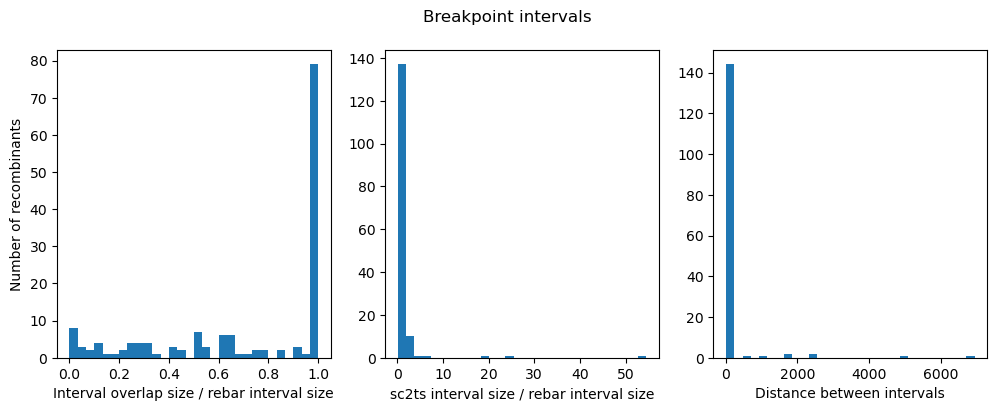

In [51]:
plot_breakpoint_interval_properties(df_novel, title="Breakpoint intervals")

Known recombinants as per rebar.

Recombinants considered as known by rebar are novel as per sc2ts because of input Viridian pango labels

In [52]:
df_known = df_recomb[df_recomb["recombinant_rebar"] != "novel"]
len(df_known)

61

In [53]:
# Cases where Pango parents are not concordant.
df_known.loc[
    ~df_known["is_parents_concordant"],
    [
        "descendants",
        "sample_pango",
        "parent_left_pango",
        "parent_right_pango",
        "left_parent_rebar",
        "right_parent_rebar",
    ]
]

,descendants,sample_pango,parent_left_pango,parent_right_pango,left_parent_rebar,right_parent_rebar
sample_id,,,,,,
ERR8691075,152,XQ,BA.1.1.15,BA.2.9,BA.1.1,BA.2.23
ERR10756327,185,XBF,BA.5.2.1,BM.1.1.1,BA.5.2.3,CJ.1
SRR20358773,1,BA.1.15,AY.25,BA.1.15,AY.41,BA.1.15.3
ERR10839902,2,XBB.1,BQ.1,XBB.1.5.18,BQ.1,XCE
ERR10381145,6,XBH,BA.2,BA.2.75.2,BF.7,BA.2.75.2
ERR9327284,1,XM,BA.1.16,BA.2.37,BA.1.16,BA.2.12
SRR20118013,1,XAS,BA.5.5,BA.2.12,BA.4,BA.2
ERR9262073,1,BA.2,BA.2.9,BA.1.15,BA.2.1,BA.1.15
ERR9858123,2,BA.4,BE.1,BA.2,BA.4,BA.2.21


In [54]:
# Cases where the breakpoint intervals do not overlap.
df_known.loc[
    ~df_known["is_overlap_with_rebar"],
    [
        "descendants",
        "interval_left",
        "interval_right",
        "left_breakpoint_rebar",
        "right_breakpoint_rebar",
        "overlap_rebar_size_ratio",
        "sc2ts_rebar_size_ratio",
        "interval_distance",
    ]
]

,descendants,interval_left,interval_right,left_breakpoint_rebar,right_breakpoint_rebar,overlap_rebar_size_ratio,sc2ts_rebar_size_ratio,interval_distance
sample_id,,,,,,,,
ERR9755541,36,10199,10447,9535,10197,0.0,0.374622,2.0
ERR10462353,6455,22332,22577,22897,22941,0.0,5.568182,320.0
ERR9909297,1,18569,22917,9867,12524,0.0,1.636432,6045.0
ERR10933490,2,27916,29729,22897,22941,0.0,41.204544,4975.0


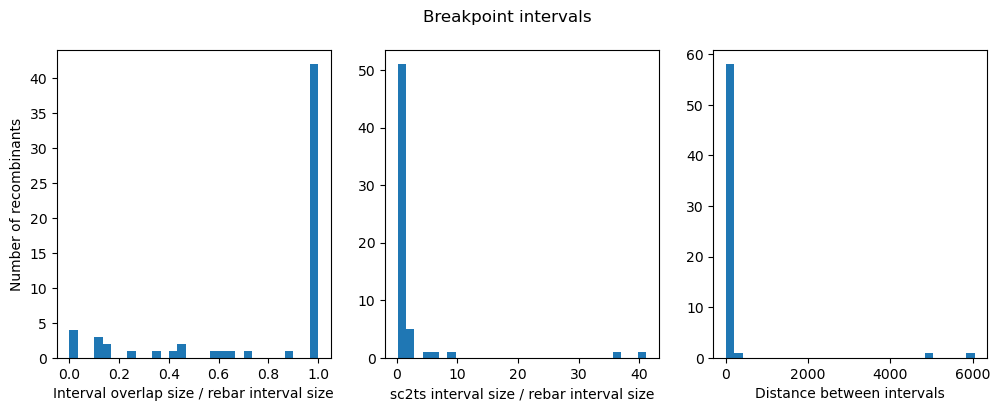

In [55]:
plot_breakpoint_interval_properties(df_known, title="Breakpoint intervals")

## Summary

### Recombinants

- There are 213 recombinants detected by both `rebar` and `sc2ts`.
- 182/213 (85.4%) have concordant parents, based on a non-sister taxa relationship.
- 201/213 (94.4%) have overlapping breakpoints.
- Parents that are not concordant tend to be close sister taxa (ex. `BA.5.2.21` vs. `BA.5.2.6`).

### Non-Recombinants

- There are 355 recombinants detected by `sc2ts` but not `rebar`.
- Only 23/355 are rebar candidates (based on number of mutations, parents as sister taxa).